In [36]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report


In [37]:
ctg = pd.read_csv('CTG.csv')

In [38]:
ctg.shape

(2129, 23)

In [39]:
ctg.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1.0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6.0,1.0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6.0,1.0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0,1.0


In [40]:
ctg.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'CLASS', 'NSP'],
      dtype='object')

In [41]:
# Fill the missing values with Mode for the target variable: NPS
ctg['NSP'].fillna(ctg['NSP'].mode()[0], inplace=True)

Text(0, 0.5, 'Frequency')

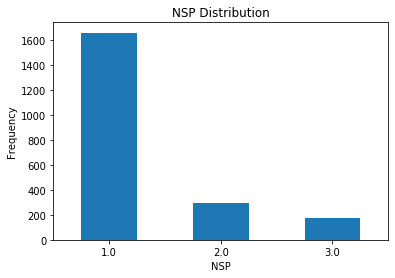

In [42]:
# Get the data distribution for different values of target variable: ‘NSP’. 

count_classes = pd.value_counts(ctg['NSP'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("NSP Distribution")
plt.xlabel("NSP")
plt.ylabel("Frequency")

In [43]:
# Here, we are considering NSP=1 as Inliers and NSP=3 as Outliers

# Discard all the datapoints having NSP=2, as this is not of our interest.
ctg=ctg.dropna()
ctg=ctg.drop(ctg[ctg['NSP']==2].index)
ctg.shape

(1831, 23)

In [44]:
pd.value_counts(ctg['NSP'])

1.0    1655
3.0     176
Name: NSP, dtype: int64

In [45]:
# Split the train, test data.
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(ctg, test_size=0.3, random_state=42)

train_x = train_x[train_x.NSP == 1] #where normal transactions
train_x = train_x.drop(['NSP'], axis=1) #drop the class column

test_y = test_x['NSP'] #save the class column for the test set
test_x = test_x.drop(['NSP'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

In [46]:
train_x.shape

(1155, 22)

In [47]:
test_x.shape

(550, 22)

In [48]:
encoding_dim=12  # code Layer will have (None, 12)  

# Define input dim = 39
input_dim=train_x.shape[1]

inputArray=Input(shape=(input_dim,))

# Define Encoder
encoded=Dense(encoding_dim, activation='tanh')(inputArray)  
   
# Define Decoder
decoded=Dense(input_dim, activation='softmax')(encoded)

# Define Auto encoder
autoencoder=Model(inputArray, decoded)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                276       
_________________________________________________________________
dense_5 (Dense)              (None, 22)                286       
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________


In [49]:
'''
Compile Model with below configurations

optimizer=ADAM, loss=binary-crossentropy and metrics=accuracy
batch_size=32 and epochs=20.
'''
# configurations of model

batch_size =32
epochs=20
autoencoder.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='ADAM')


In [50]:

train_x.shape

# 1155/32 = 36

(1155, 22)

In [51]:
train_x

array([[121.,   2.,   0., ...,  16.,   0.,   2.],
       [133.,   1.,   0., ...,  26.,   1.,   7.],
       [130.,   8.,   0., ...,   2.,   0.,   2.],
       ...,
       [132.,   0.,   0., ...,  15.,   1.,   3.],
       [122.,   1.,   0., ...,   8.,   0.,   3.],
       [121.,   0.,   0., ...,  21.,   1.,   7.]])

In [52]:
history = autoencoder.fit(train_x,train_x,epochs=20,batch_size=32,
                          validation_data=(train_x, train_x))

Epoch 1/20
37/37 [==============================] - 1s 7ms/step - loss: -29.2960 - accuracy: 0.0857 - val_loss: -42.4072 - val_accuracy: 0.3498
Epoch 2/20
37/37 [==============================] - 0s 4ms/step - loss: -52.3672 - accuracy: 0.7558 - val_loss: -63.5235 - val_accuracy: 0.0130
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: -73.6469 - accuracy: 0.0805 - val_loss: -84.8700 - val_accuracy: 8.6580e-04
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: -94.8989 - accuracy: 8.6580e-04 - val_loss: -106.0194 - val_accuracy: 8.6580e-04
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: -115.9788 - accuracy: 8.6580e-04 - val_loss: -127.0202 - val_accuracy: 8.6580e-04
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: -136.9648 - accuracy: 8.6580e-04 - val_loss: -147.9458 - val_accuracy: 8.6580e-04
Epoch 7/20
37/37 [==============================] - 0s 4ms/step - loss: -157.8152 - accuracy: 0.0000e+0

In [53]:
# Reconstruction Error and True Class

test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,550.000000,550.000000
mean,5565.206092,1.181818
std,1291.334436,0.575483
min,3480.057332,1.000000
25%,4800.461860,1.000000
50%,5481.469339,1.000000
75%,6113.224566,1.000000
max,19917.744556,3.000000


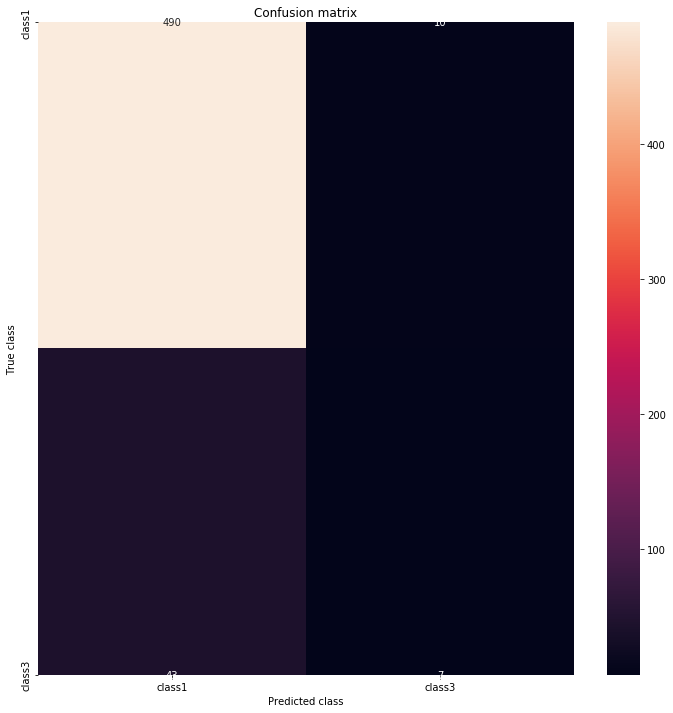

In [54]:
# Plotting the Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
LABELS = ["class1","class3"]
threshold_fixed = 4000
pred_y = [1.0 if e > threshold_fixed else 3.0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [55]:
print(classification_report(test_y,pred_y))

              precision    recall  f1-score   support

         1.0       0.92      0.98      0.95       500
         3.0       0.41      0.14      0.21        50

    accuracy                           0.90       550
   macro avg       0.67      0.56      0.58       550
weighted avg       0.87      0.90      0.88       550

